## Fault displacement  and Local Orientations 
for each  fault string:
- incementally advance along polyline every at each inter-node (no point in doing more?)
- find local stratigraphy 10m to left and right of fault
  
Once full fault has been traversed:
- Find list of contacts left 
- Find equivalent contacts on right
- use interpolated orientations to estimate minimum true offset assuming vertical displacement and store 
- if no equivalent found, flag as domain fault and find min strat offset for contact, use cumulative minimum thickness estimate and store with flag (not implemented)
- estimate median & sd of minimum fault offset and store with flag (not implemented)

Local Orientations
Since much of the code is the same, we benefit by calculating local orientation data either side of fault so that geomodeller/gempy have satisfied fault compartment orientation data

#### Needs to be incorporated in base code so that variations between WFS and shapefile field case and formation name changes between versions don't make it crash

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import os
import sys
import stat
import functools 
import operator  
import matplotlib
import networkx as nx
import rasterio
from shapely.geometry import Polygon
from shapely.geometry import Point
from geopandas import GeoDataFrame
from math import sin, cos, tan, atan, atan2, asin, radians, degrees, sqrt, pow, acos, fabs
from map2loop import m2l_utils
from map2loop import m2l_topology
from map2loop import m2l_geometry
from map2loop import m2l_interpolation
%matplotlib inline

In [2]:
test_data_name='test_data3'

test_data_path='../'+test_data_name+'/'

os.chdir(test_data_path)
%run -i "m2l_config.py"
#%run -i "../test_data3/m2l_config.py"
print(os.getcwd())

bbox2=str(minx)+","+str(miny)+","+str(maxx)+","+str(maxy)
lat_point_list = [miny, miny, maxy, maxy, maxy]
lon_point_list = [minx, maxx, maxx, minx, minx]
bbox_geom = Polygon(zip(lon_point_list, lat_point_list))
polygon = gpd.GeoDataFrame(index=[0], crs=dst_crs, geometry=[bbox_geom]) 
bbox=(minx,miny,maxx,maxy)

Default parameters loaded from ../test_data3/m2l_config.py:
#ROI

step_out=0.1   #padding arounf dtm to ensure reprojected dtm covers target area (in degrees)
inset=0      #unused??

minx=500057  #region of interest coordinates in metre-based system (or non-degree system)
maxx=603028
miny=7455348
maxy=7567953
model_top=1200
model_base=-8200

#PATHS

test_data_path='../test_data3/'
geology_file='hams2_geol.shp'   #input geology file (if local)
fault_file='GEOS_GEOLOGY_LINEARSTRUCTURE_500K_GSD.shp' #input fault file (if local)
structure_file='hams2_structure.shp' #input bedding orientation file (if local)
m2m_cpp_path='../m2m_cpp/'


#CRS

src_crs = {'init': 'EPSG:4326'}  # coordinate reference system for imported dtms (geodetic lat/long WGS84)
dst_crs = {'init': 'EPSG:28350'} # coordinate system for data

#codes and labels these refer to specific fields (codes) in GIS layer or database that contain the info needed for these calcs and text substrings (labels) in the contents of these fie

In [3]:
local_paths=True



In [4]:
loopwfs=m2l_utils.have_access("geo.loop-gis.org")
hawaii=m2l_utils.have_access("pae-paha.pacioos.hawaii.edu")

if(not (loopwfs & hawaii)):
    local_paths=True
    net=False
    print('using local paths')
else:
    net=True
    
if((not local_paths) and net):
    structure_file='http://geo.loop-gis.org/geoserver/loop/wfs?service=WFS&version=1.1.0&request=GetFeature&typeName=warox_points_f5011&bbox='+bbox2+'&srs=EPSG:28350'
    fault_file='http://geo.loop-gis.org/geoserver/loop/wfs?service=WFS&version=1.1.0&request=GetFeature&typeName=linear_500k&bbox='+bbox2+'&srs=EPSG:28350'
    geology_file='http://geo.loop-gis.org/geoserver/loop/wfs?service=WFS&version=1.0.0&request=GetFeature&typeName=loop:geol_500k&bbox='+bbox2+'&srs=EPSG:28350'

    c_l= {
    #Orientations
      "d": "dip",                  #field that contains dip information
      "dd": "dip_dir",             #field that contains dip direction information
      "sf": 'feature',             #field that contains information on type of structure
      "bedding": 'Bed',            #text to search for in field defined by sfcode to show that this is a bedding measurement
    #Stratigraphy
      "g": 'group_',               #field that contains coarser stratigraphic coding
      "c": 'code',                 #field that contains finer stratigraphic coding
      "ds": 'descriptn',           #field that contains information about lithology
      "u": 'unitname',             #field that contains alternate stratigraphic coding (not used??)
      "r1": 'rocktype1',           #field that contains  extra lithology information
      "r2": 'rocktype2',           #field that contains even more lithology information
      "sill": 'sill',              #text to search for in field defined by dscode to show that this is a sill
      "intrusive": 'intrusive',    #text to search for in field defined by dscode to show that this is an intrusion
      "volcanic": 'volcanic',      #text to search for in field defined by dscode to show that this is an intrusion
    #Timing
      "min": 'min_age_ma',         #field that contains minimum age of unit defined by ccode
      "max": 'max_age_ma',         #field that contains maximum age of unit defined by ccode
    #faults and folds
      "f": 'feature',              #field that contains information on type of structure
      "fault": 'Fault',            #text to search for in field defined by fcode to show that this is a fault
      "fold": 'Fold axial trace',  #text to search for in field defined by fcode to show that this is a fold axial trace
      "n": 'name',                 #field that contains information on name of fault (not used??)
      "t": 'type',                 #field that contains information on type of fold
    #ids
      "o": 'objectid',             #field that contains unique id of geometry object
      "gi": 'geopnt_id'            #field that contains unique id of structure point
    }

available: geo.loop-gis.org
available: pae-paha.pacioos.hawaii.edu


In [ ]:
use_gcode=('Hamersley Group','Fortescue Group','Wyloo Group','Shingle Creek Group','Turee Creek Group' ) 
use_gcode2=('Hamersley_Group','Fortescue_Group','Wyloo_Group','Shingle_Creek_Group','Turee_Creek_Group' ) 

m2l_interpolation.process_fault_throw_and_near_orientations(tmp_path,output_path,dtm_reproj_file,c_l,use_gcode,use_gcode2,dst_crs,bbox,scheme)

In [ ]:
# old code vvvvvvvv

In [5]:
def process_fault_throw_and_near_orientations(tmp_path,output_path,c_l,use_gcode,use_gcode2,bbox,scheme):
    fault_file=tmp_path+'faults_clip.shp'
    geology_file=tmp_path+'geol_clip.shp'

    faults = gpd.read_file(fault_file)
    geology = gpd.read_file(geology_file)

    all_long_faults=np.genfromtxt(output_path+'fault_dimensions.csv',delimiter=',',dtype='U25')
    fault_names=all_long_faults[1:,:1]
    
    xi=[]
    yi=[]
    fdc=[]
    all_coordsdist=[]
    all_coords_x=[]
    all_coords_y=[]

    for index,fault in faults.iterrows():
        if('Fault_'+str(fault[c_l['o']]) in fault_names):
            #print('--------------------------',fault.OBJECTID)
            lcoords=[]
            rcoords=[]
            index=[]
            for i in range (0,len(fault.geometry.coords)-1):
                midx=fault.geometry.coords[i][0]+((fault.geometry.coords[i+1][0]-fault.geometry.coords[i][0])/2.0)            
                midy=fault.geometry.coords[i][1]+((fault.geometry.coords[i+1][1]-fault.geometry.coords[i][1])/2.0)
                l,m=m2l_utils.pts2dircos(fault.geometry.coords[i][0],fault.geometry.coords[i][1],fault.geometry.coords[i+1][0],fault.geometry.coords[i+1][1])
                lcoords.append([(midx+(10*m),midy-(10*l))])
                rcoords.append([(midx-(10*m),midy+(10*l))])
                all_coords_x.append((midx+(10*m)))
                all_coords_x.append((midx-(10*m)))
                all_coords_y.append((midy-(10*l)))
                all_coords_y.append((midy+(10*l)))
                index.append([(i)])
            lgeom=[Point(xy) for xy in lcoords]        
            rgeom=[Point(xy) for xy in rcoords]
            lgdf = GeoDataFrame(index, crs=dst_crs, geometry=lgeom)
            rgdf = GeoDataFrame(index, crs=dst_crs, geometry=rgeom)
            lcode = gpd.sjoin(lgdf, geology, how="left", op="within")        
            rcode = gpd.sjoin(rgdf, geology, how="left", op="within")
            lcontact=[]
            rcontact=[]
            lastlcode=''
            lastrcode=''
            for indl in lcode.iterrows():
                if(indl[0]<len(lcode)):
                    if((not indl[1][c_l['c']]==lastlcode) and ((not c_l['sill'] in indl[1][c_l['ds']]) or (not c_l['intrusive'] in indl[1][c_l['r1']] ))):
                        lcontact.append([(indl[0],lastlcode,indl[1][c_l['c']])])
                    lastlcode=indl[1][c_l['c']]
            for indr in rcode.iterrows():
                if(indr[0]<len(rcode)):
                    if((not indr[1][c_l['c']]==lastlcode) and ((not c_l['sill'] in indr[1][c_l['ds']]) or (not c_l['intrusive'] in indr[1][c_l['r1']] ))):
                        rcontact.append([(indr[0],lastrcode,indr[1][c_l['c']])]) 
                    lastrcode=indr[1][c_l['c']]

            for lc in lcontact:
                for rc in rcontact:
                    if(lc[0][1]==rc[0][1] and lc[0][2]==rc[0][2] and not lc[0][1]==''):
                        dist=sqrt(pow(fault.geometry.coords[lc[0][0]][0]-fault.geometry.coords[rc[0][0]][0],2.0)+
                                  pow(fault.geometry.coords[lc[0][0]][1]-fault.geometry.coords[rc[0][0]][1],2.0))
                        if(lc[0][0]<rc[0][0]):
                            dist=-dist

                        xi.append((fault.geometry.coords[lc[0][0]][0]))
                        yi.append((fault.geometry.coords[lc[0][0]][1]))
                        l,m=m2l_utils.pts2dircos(fault.geometry.coords[lc[0][0]][0],fault.geometry.coords[lc[0][0]][1]
                                                      ,fault.geometry.coords[rc[0][0]][0],fault.geometry.coords[rc[0][0]][1])
                        fdc.append((l,m,'Fault_'+str(fault.OBJECTID)))
                        all_coordsdist.append((dist))

    structure_file=tmp_path+'structure_clip.shp'
    #bbox=(minx+inset,miny+inset,maxx-inset,maxy-inset)
    
    m2l_interpolation.interpolate_orientations(structure_file,tmp_path,bbox,c_l,use_gcode,scheme,xi,yi,True)
    m2l_interpolation.interpolate_orientations(structure_file,tmp_path+'ex_',bbox,c_l,use_gcode,scheme,all_coords_x,all_coords_y,True)    
    
    basal_contacts_file=tmp_path+'basal_contacts.shp'

    dtm = rasterio.open(dtm_reproj_file)

    m2l_interpolation.interpolate_contacts(basal_contacts_file,tmp_path,dtm,bbox,c_l,use_gcode2,scheme,xi,yi,True)
    m2l_interpolation.interpolate_contacts(basal_contacts_file,tmp_path+'ex_',dtm,bbox,c_l,use_gcode2,scheme,all_coords_x,all_coords_y,True)    
    
    combo_file=tmp_path+'f_combo.csv'
    ex_combo_file=tmp_path+'ex_f_combo.csv'

    lc=np.loadtxt(tmp_path+'f_interpolation_contacts_l.csv',skiprows =1,delimiter =',',dtype=float)
    mc=np.loadtxt(tmp_path+'f_interpolation_contacts_m.csv',skiprows =1,delimiter =',',dtype=float)
    lo=np.loadtxt(tmp_path+'f_interpolation_l.csv',skiprows =1,delimiter =',',dtype=float)
    mo=np.loadtxt(tmp_path+'f_interpolation_m.csv',skiprows =1,delimiter =',',dtype=float)
    no=np.loadtxt(tmp_path+'f_interpolation_n.csv',skiprows =1,delimiter =',',dtype=float)
    xy=np.loadtxt(tmp_path+'f_interpolation_'+scheme+'.csv',skiprows =1,delimiter =',',dtype=float)

    ex_lc=np.loadtxt(tmp_path+'ex_f_interpolation_contacts_l.csv',skiprows =1,delimiter =',',dtype=float)
    ex_mc=np.loadtxt(tmp_path+'ex_f_interpolation_contacts_m.csv',skiprows =1,delimiter =',',dtype=float)
    ex_lo=np.loadtxt(tmp_path+'ex_f_interpolation_l.csv',skiprows =1,delimiter =',',dtype=float)
    ex_mo=np.loadtxt(tmp_path+'ex_f_interpolation_m.csv',skiprows =1,delimiter =',',dtype=float)
    ex_no=np.loadtxt(tmp_path+'ex_f_interpolation_n.csv',skiprows =1,delimiter =',',dtype=float)
    ex_xy=np.loadtxt(tmp_path+'ex_f_interpolation_'+scheme+'.csv',skiprows =1,delimiter =',',dtype=float)

    m2l_interpolation.join_contacts_and_orientations(combo_file,geology_file,tmp_path,dtm_reproj_file,c_l,lo,mo,no,lc,mc,xy,dst_crs,bbox,True)
    m2l_interpolation.join_contacts_and_orientations(ex_combo_file,geology_file,tmp_path+'ex_',dtm_reproj_file,c_l,ex_lo,ex_mo,ex_no,ex_lc,ex_mc,ex_xy,dst_crs,bbox,True)

    ddd=pd.read_csv(tmp_path+'f_combo_full.csv')
    f=open(output_path+'fault_displacements3.csv','w')
    f.write('X,Y,fname,apparent_displacement,vertical_displacement\n')

    for i in range (len(ddd)):
        l,m,n=m2l_utils.ddd2dircos(ddd.iloc[i]['dip'],ddd.iloc[i]['azimuth'])
        lnorm=l/sqrt(pow(l,2)+pow(m,2))
        mnorm=m/sqrt(pow(l,2)+pow(m,2))
        dotproduct=fabs((fdc[i][0]*lnorm)+(fdc[i][1]*mnorm))
        #print(all_coordsdist[i],all_coordsdist[i]*tan(radians(dotproduct*ddd.iloc[i]['dip'])))
        ostr=str(xi[i])+','+str(yi[i])+','+str(fdc[i][2])+','+str(int(all_coordsdist[i]))+','+str(abs(int(all_coordsdist[i]*tan(radians(dotproduct*ddd.iloc[i]['dip'])))))+'\n'
        f.write(ostr)

    f.close()

C:\Users\00073294\AppData\Local\Continuum\anaconda3\lib\site-packages\geopandas\tools\sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')


orientations interpolated as dip dip direction ../test_data3/tmp/f_interpolation_scipy_rbf.csv
orientations interpolated as l,m,n dir cos ../test_data3/tmp/f_interpolation_l.csv etc.
orientations interpolated as dip dip direction ../test_data3/tmp/ex_f_interpolation_scipy_rbf.csv
orientations interpolated as l,m,n dir cos ../test_data3/tmp/ex_f_interpolation_l.csv etc.
contacts interpolated as strike ../test_data3/tmp/f_interpolation_contacts_scipy_rbf.csv
contacts interpolated as l,m dir cos ../test_data3/tmp/f_interpolation_contacts_l.csv etc.
contacts interpolated as strike ../test_data3/tmp/ex_f_interpolation_contacts_scipy_rbf.csv
contacts interpolated as l,m dir cos ../test_data3/tmp/ex_f_interpolation_contacts_l.csv etc.
{'init': 'EPSG:28350'} None
contacts and orientations interpolated as dip dip direction ../test_data3/tmp/f_combo_full.csv
{'init': 'EPSG:28350'} None
contacts and orientations interpolated as dip dip direction ../test_data3/tmp/ex_f_combo_full.csv


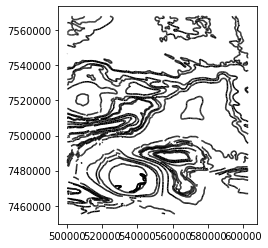

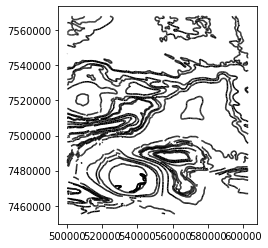

In [ ]:
fault_file=tmp_path+'faults_clip.shp'
geology_file=tmp_path+'geol_clip.shp'

faults = gpd.read_file(fault_file)
geology = gpd.read_file(geology_file)
display(faults,geology)
all_long_faults=np.genfromtxt(output_path+'fault_dimensions.csv',delimiter=',',dtype='U25')
fault_names=all_long_faults[1:,:1]
print(fault_names[0][0])

In [ ]:
xi=[]
yi=[]
fdc=[]
all_coordsdist=[]
all_coords_x=[]
all_coords_y=[]
display(c_l)
for index,fault in faults.iterrows():
    if('Fault_'+str(fault[c_l['o']]) in fault_names):
        #print('--------------------------',fault.OBJECTID)
        lcoords=[]
        rcoords=[]
        index=[]
        for i in range (0,len(fault.geometry.coords)-1):
            midx=fault.geometry.coords[i][0]+((fault.geometry.coords[i+1][0]-fault.geometry.coords[i][0])/2.0)            
            midy=fault.geometry.coords[i][1]+((fault.geometry.coords[i+1][1]-fault.geometry.coords[i][1])/2.0)
            l,m=m2l_utils.pts2dircos(fault.geometry.coords[i][0],fault.geometry.coords[i][1],fault.geometry.coords[i+1][0],fault.geometry.coords[i+1][1])
            lcoords.append([(midx+(10*m),midy-(10*l))])
            rcoords.append([(midx-(10*m),midy+(10*l))])
            all_coords_x.append((midx+(10*m)))
            all_coords_x.append((midx-(10*m)))
            all_coords_y.append((midy-(10*l)))
            all_coords_y.append((midy+(10*l)))
            index.append([(i)])
        lgeom=[Point(xy) for xy in lcoords]        
        rgeom=[Point(xy) for xy in rcoords]
        lgdf = GeoDataFrame(index, crs=dst_crs, geometry=lgeom)
        rgdf = GeoDataFrame(index, crs=dst_crs, geometry=rgeom)
        lcode = gpd.sjoin(lgdf, geology, how="left", op="within")        
        rcode = gpd.sjoin(rgdf, geology, how="left", op="within")
        lcontact=[]
        rcontact=[]
        lastlcode=''
        lastrcode=''
        for indl in lcode.iterrows():
            if(indl[0]<len(lcode)):
                if((not indl[1][c_l['c']]==lastlcode) and ((not c_l['sill'] in indl[1][c_l['ds']]) or (not c_l['intrusive'] in indl[1][c_l['r1']] ))):
                    lcontact.append([(indl[0],lastlcode,indl[1][c_l['c']])])
                lastlcode=indl[1][c_l['c']]
        for indr in rcode.iterrows():
            if(indr[0]<len(rcode)):
                if((not indr[1][c_l['c']]==lastlcode) and ((not c_l['sill'] in indr[1][c_l['ds']]) or (not c_l['intrusive'] in indr[1][c_l['r1']] ))):
                    rcontact.append([(indr[0],lastrcode,indr[1][c_l['c']])]) 
                lastrcode=indr[1][c_l['c']]

        for lc in lcontact:
            for rc in rcontact:
                if(lc[0][1]==rc[0][1] and lc[0][2]==rc[0][2] and not lc[0][1]==''):
                    dist=sqrt(pow(fault.geometry.coords[lc[0][0]][0]-fault.geometry.coords[rc[0][0]][0],2.0)+
                              pow(fault.geometry.coords[lc[0][0]][1]-fault.geometry.coords[rc[0][0]][1],2.0))
                    if(lc[0][0]<rc[0][0]):
                        dist=-dist

                    xi.append((fault.geometry.coords[lc[0][0]][0]))
                    yi.append((fault.geometry.coords[lc[0][0]][1]))
                    l,m=m2l_utils.pts2dircos(fault.geometry.coords[lc[0][0]][0],fault.geometry.coords[lc[0][0]][1]
                                                  ,fault.geometry.coords[rc[0][0]][0],fault.geometry.coords[rc[0][0]][1])
                    fdc.append((l,m,'Fault_'+str(fault.OBJECTID)))
                    all_coordsdist.append((dist))
                    

    

In [ ]:
display(xi)

In [ ]:
def call_interpolator_for_faults(calc,x,y,l,m,n,xi,yi,nx,ny):
    # Calculate IDW or other interpolators

    #display(x)
    #display(y)
    #display(l)
    #display(m)
    #display(xi)
    #display(yi)
    #display(nx)
    #display(ny)
        
    if(calc=='simple_idw'):
        ZIl = simple_idw(x,y,l,xi,yi)
    if(calc=='scipy_rbf'):
        ZIl = m2l_interpolation.scipy_rbf(x,y,l,xi,yi)
    if(calc=='scipy_idw'):
        ZIl = scipy_idw(x,y,l,xi,yi)
    #ZIl = ZIl.reshape((ny, nx))
    
    if(calc=='simple_idw'):
        ZIm = simple_idw(x,y,m,xi,yi)
    if(calc=='scipy_rbf'):
        ZIm = m2l_interpolation.scipy_rbf(x,y,m,xi,yi)
    if(calc=='scipy_idw'):
        ZIm = scipy_idw(x,y,m,xi,yi)
    #ZIm = ZIm.reshape((ny, nx))
    
    if(type(n) is not int):
        if(calc=='simple_idw'):
            ZIn = simple_idw(x,y,n,xi,yi)
        if(calc=='scipy_rbf'):
            ZIn = m2l_interpolation.scipy_rbf(x,y,n,xi,yi)
        if(calc=='scipy_idw'):
            ZIn = scipy_idw(x,y,n,xi,yi)
    #ZIn = ZIn.reshape((ny, nx))   
    else:
        ZIn=0
        
    return(ZIl,ZIm,ZIn)

def interpolate_orientations_for_faults(structure_file,output_path,bbox,c_l,this_gcode,calc,xi,yi):
    structure = gpd.read_file(structure_file,bbox=bbox)
    
    if(len(this_gcode)==1):       
        is_gp=structure[c_l['g']] == thisgcode # subset orientations to just those with this group
        gp_structure = structure[is_gp]
        print('single group')
        display(gp_structure)
    else:
        print('first code',this_gcode[0])
        is_gp=structure[c_l['g']] == this_gcode[0] # subset orientations to just those with this group
        gp_structure = structure[is_gp]
        gp_structure_all = gp_structure.copy()
        print('first group')
        #display(gp_structure)

        for i in range (1,len(this_gcode)):
            print('next code',this_gcode[i])
            is_gp=structure[c_l['g']] == this_gcode[i] # subset orientations to just those with this group
            temp_gp_structure = structure[is_gp]
            gp_structure_all = pd.concat([gp_structure_all, temp_gp_structure], ignore_index=True)
            print('next group')
            #display(gp_structure)

    npts = len(gp_structure_all)
    
    nx, ny = len(xi),len(yi)

    #xi = np.linspace(bbox[0],bbox[2], nx)
    #yi = np.linspace(bbox[1],bbox[3], ny)
    #xi, yi = np.meshgrid(xi, yi)
    #xi, yi = xi.flatten(), yi.flatten()
    x = np.zeros(npts)
    y = np.zeros(npts)
    dip = np.zeros(npts)
    dipdir = np.zeros(npts)
    
    i=0
    for a_pt in gp_structure_all.iterrows():
        x[i]=a_pt[1]['geometry'].x
        y[i]=a_pt[1]['geometry'].y
        dip[i] = a_pt[1][c_l['d']]
        dipdir[i] = a_pt[1][c_l['dd']]
        i=i+1
    
    l=np.zeros(npts)
    m=np.zeros(npts)
    n=np.zeros(npts)
    
    for i in range(0,npts):
        l[i],m[i],n[i]=m2l_utils.ddd2dircos(dip[i],dipdir[i])

    ZIl,ZIm,ZIn=call_interpolator_for_faults(calc,x,y,l,m,n,xi,yi,nx,ny)
    
    # Comparisons...
    #plot(x,-y,l,ZIl)
    #plt.title('l')
    #plot(x,-y,m,ZIm)
    #plt.title('m')
    #plot(x,-y,n,ZIn)
    #plt.title('n')
    
    #plt.show()
    print(npts,len(xi))
    f=open(output_path+'f_input.csv','w')
    fi=open(output_path+'f_interpolation_'+calc+'.csv','w')
    fl=open(output_path+'f_interpolation_l.csv','w')
    fm=open(output_path+'f_interpolation_m.csv','w')
    fn=open(output_path+'f_interpolation_n.csv','w')
    
    f.write("x,y,dip,dipdirection\n")
    fi.write("x,y,dip,dipdirection\n")
    fl.write("x,y,l\n")
    fm.write("x,y,m\n")
    fn.write("x,y,n\n")
    
    for i in range (0,npts):
        ostr=str(x[i])+","+str(y[i])+","+str(int(dip[i]))+","+str(int(dipdir[i]))+'\n'
        f.write(ostr)
    
    for i in range (0,len(xi)):
            L=ZIl[i]/(sqrt((pow(ZIl[i],2.0))+(pow(ZIm[i],2.0))+(pow(ZIn[i],2.0))))
            M=ZIm[i]/(sqrt((pow(ZIl[i],2.0))+(pow(ZIm[i],2.0))+(pow(ZIn[i],2.0))))
            N=ZIn[i]/(sqrt((pow(ZIl[i],2.0))+(pow(ZIm[i],2.0))+(pow(ZIn[i],2.0))))
            
            dip,dipdir=m2l_utils.dircos2ddd(L,M,N)

            ostr=str(xi[i])+","+str(yi[i])+","+str(int(dip))+","+str(int(dipdir))+'\n'
            fi.write(ostr)
            
            ostr=str(xi[i])+","+str(yi[i])+","+str(L)+'\n'
            fl.write(ostr)
            ostr=str(xi[i])+","+str(yi[i])+","+str(M)+'\n'
            fm.write(ostr)
            ostr=str(xi[i])+","+str(yi[i])+","+str(N)+'\n'
            fn.write(ostr)
    
    f.close()
    fi.close()
    fl.close()
    fm.close()
    fn.close()
    
    #fig, ax = plt.subplots(figsize=(10, 10),)
    #q = ax.quiver(xi, yi, -ZIm, ZIl,headwidth=0)
    #plt.show()
    print("orientations interpolated as dip dip direction",output_path+'interpolation_'+calc+'.csv')
    print("orientations interpolated as l,m,n dir cos",output_path+'interpolation_l.csv etc.')

In [ ]:
use_gcode=('Hamersley Group','Fortescue Group','Wyloo Group','Shingle Creek Group','Turee Creek Group' ) ################# MOVE UP   #########################
structure_file=tmp_path+'structure_clip.shp'
bbox=(minx+inset,miny+inset,maxx-inset,maxy-inset)

interpolate_orientations_for_faults(structure_file,tmp_path,bbox,c_l,use_gcode,scheme,xi,yi)
interpolate_orientations_for_faults(structure_file,tmp_path+'ex_',bbox,c_l,use_gcode,scheme,all_coords_x,all_coords_y)

In [ ]:
def interpolate_contacts_for_faults(geology_file,output_path,dtm,bbox,c_l,use_gcode,calc,xi,yi):
    geol_file = gpd.read_file(geology_file,bbox=bbox)
    print(len(geol_file))
    geol_file.plot( color='black',edgecolor='black') 
    
    # Setup: Generate data...
    npts = 0
    decimate=1
    nx, ny = len(xi),len(yi)

    #xi = np.linspace(bbox[0],bbox[2], nx)
    #yi = np.linspace(bbox[1],bbox[3], ny)
    #xi, yi = np.meshgrid(xi, yi)
    #xi, yi = xi.flatten(), yi.flatten()
    x = np.zeros(20000)   ############## FUDGE ################
    y = np.zeros(20000)
    l = np.zeros(20000)
    m = np.zeros(20000)
    f=open(output_path+'f_raw_contacts.csv','w')
    f.write("X,Y,Z,angle,lsx,lsy,formation,group\n")
    j=0
    i=0
    for acontact in geol_file.iterrows():   #loop through distinct linestrings in MultiLineString
        if(acontact[1].geometry.type=='MultiLineString'):
            #print(i)
            for line in acontact[1].geometry: # loop through line segments
                #print(i,len(acontact[1].geometry))
                if(m2l_utils.mod_safe(i,decimate)  ==0 and acontact[1][c_l['g']] in use_gcode):
                    #if(acontact[1]['id']==170): 
                        #display(npts,line.coords[0][0],line.coords[1][0]) 
                    dlsx=line.coords[0][0]-line.coords[1][0]
                    dlsy=line.coords[0][1]-line.coords[1][1]
                    if(not line.coords[0][0]==line.coords[1][0] or not line.coords[0][1]==line.coords[1][1]):               
                        lsx=dlsx/sqrt((dlsx*dlsx)+(dlsy*dlsy))
                        lsy=dlsy/sqrt((dlsx*dlsx)+(dlsy*dlsy))
                        x[i]=line.coords[1][0]+(dlsx/2)
                        y[i]=line.coords[1][1]+(dlsy/2)
                        angle=degrees(atan2(lsx,lsy))
                        l[i]=lsx
                        m[i]=lsy
                        locations=[(x[i],y[i])] #doesn't like point right on edge?
                        height=m2l_utils.value_from_raster(dtm,locations)
                        if(str(acontact[1][c_l['g']])=='None'):
                            ostr=str(x[i])+","+str(y[i])+","+str(height)+","+str(angle%180)+","+str(lsx)+","+str(lsy)+","+acontact[1][c_l['c']].replace(" ","_").replace("-","_")+","+acontact[1][c_l['c']].replace(" ","_").replace("-","_")+"\n"
                        else:
                            ostr=str(x[i])+","+str(y[i])+","+str(height)+","+str(angle%180)+","+str(lsx)+","+str(lsy)+","+acontact[1][c_l['c']].replace(" ","_").replace("-","_")+","+acontact[1][c_l['g']].replace(" ","_").replace("-","_")+"\n"
                        f.write(ostr)
                        npts=npts+1
                i=i+1
        else:
            #display(acontact[1].geometry,acontact[1].geometry.coords)
            #for line in acontact[1]: # loop through line segments in LineString
            if(  m2l_utils.mod_safe(i,decimate)  ==0 and acontact[1][c_l['g']] in use_gcode):
                dlsx=acontact[1].geometry.coords[0][0]-acontact[1].geometry.coords[1][0]
                dlsy=acontact[1].geometry.coords[0][1]-acontact[1].geometry.coords[1][1]
                if(not acontact[1].geometry.coords[0][0]==acontact[1].geometry.coords[1][0] 
                   or not acontact[1].geometry.coords[0][1]==acontact[1].geometry.coords[1][1]):
                    lsx=dlsx/sqrt((dlsx*dlsx)+(dlsy*dlsy))
                    lsy=dlsy/sqrt((dlsx*dlsx)+(dlsy*dlsy))
                    x[i]=acontact[1].geometry.coords[1][0]+(dlsx/2)
                    y[i]=acontact[1].geometry.coords[1][1]+(dlsy/2)
                    angle=degrees(atan2(lsx,lsy))
                    l[i]=lsx
                    m[i]=lsy
                    locations=[(x[i],y[i])] #doesn't like point right on edge?
                    height=m2l_utils.value_from_raster(dtm,locations)
                    if(str(acontact[1][c_l['g']])=='None'):
                        ostr=str(x[i])+","+str(y[i])+","+str(height)+","+str(angle%180)+","+str(lsx)+","+str(lsy)+","+acontact[1][c_l['c']].replace(" ","_").replace("-","_")+","+acontact[1][c_l['c']].replace(" ","_").replace("-","_")+"\n"
                    else:
                        ostr=str(x[i])+","+str(y[i])+","+str(height)+","+str(angle%180)+","+str(lsx)+","+str(lsy)+","+acontact[1][c_l['c']].replace(" ","_").replace("-","_")+","+acontact[1][c_l['g']].replace(" ","_").replace("-","_")+"\n"
                    #print(ostr)
                    f.write(ostr)
                    print(npts,dlsx,dlsy)
                    npts=npts+1
                i=i+1
        j=j+1
    f.close()
    print("i",i,"npts",npts)

    for i in range(0,npts):
        x[i]=x[i]+(np.random.ranf()*0.01)
        y[i]=y[i]+(np.random.ranf()*0.01)

    ZIl,ZIm,ZIn=call_interpolator_for_faults(calc,x[:npts],y[:npts],l[:npts],m[:npts],0,xi,yi,nx,ny)    
    
    # Comparisons...
    #plot(x,-y,l,ZIl)
    #plt.title('l')
    #plot(x,-y,m,ZIm)
    #plt.title('m')

    fi=open(output_path+'f_interpolation_contacts_'+calc+'.csv','w')
    fl=open(output_path+'f_interpolation_contacts_l.csv','w')
    fm=open(output_path+'f_interpolation_contacts_m.csv','w')
    
    fi.write("x,y,angle\n")
    fl.write("x,y,l\n")
    fm.write("x,y,m\n")
    
    for i in range (0,len(xi)):
            L=ZIl[i]/(sqrt((pow(ZIl[i],2.0))+(pow(ZIm[i],2.0))))
            M=ZIm[i]/(sqrt((pow(ZIl[i],2.0))+(pow(ZIm[i],2.0))))
            S=degrees(atan2(L,M))
    
            ostr=str(xi[i])+","+str(yi[i])+","+str(int(S))+'\n'
            fi.write(ostr)
            
            ostr=str(xi[i])+","+str(yi[i])+","+str(L)+'\n'
            fl.write(ostr)
            ostr=str(xi[i])+","+str(yi[i])+","+str(M)+'\n'
            fm.write(ostr)
    fi.close()
    fl.close()
    fm.close()
    #fig, ax = plt.subplots(figsize=(10, 10))
    #q = ax.quiver(xi, yi, ZIl, ZIm,headwidth=0)
    #plt.show()
    print("contacts interpolated as strike",output_path+'f_interpolation_contacts_'+calc+'.csv')
    print("contacts interpolated as l,m dir cos",output_path+'f_interpolation_contacts_l.csv etc.')

In [ ]:
geology_file=tmp_path+'basal_contacts.shp'

dtm = rasterio.open(dtm_reproj_file)
use_gcode=('Hamersley_Group','Fortescue_Group','Wyloo_Group','Shingle_Creek_Group','Turee_Creek_Group' ) ################# MOVE UP   #########################

interpolate_contacts_for_faults(geology_file,tmp_path,dtm,bbox,c_l,use_gcode,scheme,xi,yi)
interpolate_contacts_for_faults(geology_file,tmp_path+'ex_',dtm,bbox,c_l,use_gcode,scheme,all_coords_x,all_coords_y)

In [ ]:
geology_file=tmp_path+'geol_clip.shp'
combo_file=tmp_path+'f_combo.csv'
ex_combo_file=tmp_path+'ex_f_combo.csv'

lc=np.loadtxt(tmp_path+'f_interpolation_contacts_l.csv',skiprows =1,delimiter =',',dtype=float)
mc=np.loadtxt(tmp_path+'f_interpolation_contacts_m.csv',skiprows =1,delimiter =',',dtype=float)
lo=np.loadtxt(tmp_path+'f_interpolation_l.csv',skiprows =1,delimiter =',',dtype=float)
mo=np.loadtxt(tmp_path+'f_interpolation_m.csv',skiprows =1,delimiter =',',dtype=float)
no=np.loadtxt(tmp_path+'f_interpolation_n.csv',skiprows =1,delimiter =',',dtype=float)
xy=np.loadtxt(tmp_path+'f_interpolation_'+scheme+'.csv',skiprows =1,delimiter =',',dtype=float)

ex_lc=np.loadtxt(tmp_path+'ex_f_interpolation_contacts_l.csv',skiprows =1,delimiter =',',dtype=float)
ex_mc=np.loadtxt(tmp_path+'ex_f_interpolation_contacts_m.csv',skiprows =1,delimiter =',',dtype=float)
ex_lo=np.loadtxt(tmp_path+'ex_f_interpolation_l.csv',skiprows =1,delimiter =',',dtype=float)
ex_mo=np.loadtxt(tmp_path+'ex_f_interpolation_m.csv',skiprows =1,delimiter =',',dtype=float)
ex_no=np.loadtxt(tmp_path+'ex_f_interpolation_n.csv',skiprows =1,delimiter =',',dtype=float)
ex_xy=np.loadtxt(tmp_path+'ex_f_interpolation_'+scheme+'.csv',skiprows =1,delimiter =',',dtype=float)

def join_contacts_and_orientations_for_faults(combo_file,geology_file,output_path,dtm_reproj_file,c_l,lo,mo,no,lc,mc,xy,dst_crs,bbox):
    f=open(combo_file,'w')
    f.write('x,y,dip,dipdirection,misorientation,dotproduct\n')

    for i in range(0,len(lc)):
        scale=sqrt(1-pow(no[i,2],2)) #scaling contact dircos to *include* dip info
        lcscaled=scale*-mc[i,2] #includes 90 rotation to account for orthogonality of contact and dip direction
        mcscaled=scale*lc[i,2]
        scale2=sqrt(pow(lo[i,2],2)+pow(mo[i,2],2)) #scaling dip dipdir dircos to *exclude* dip info
        loscaled=lo[i,2]/scale2
        moscaled=mo[i,2]/scale2
        dotproduct=(-mc[i,2]*loscaled)+(lc[i,2]*moscaled) #includes 90 rotation to account for orthogonality of contact and dip direction
        if(dotproduct<0):
            lcscaled=-lcscaled
            mcscaled=-mcscaled
        misorientation=degrees(acos(dotproduct))
        dip,dipdir=m2l_utils.dircos2ddd(lcscaled,mcscaled,no[i,2])
        ostr=str(xy[i,0])+','+str(xy[i,1])+','+str(int(dip))+','+str(int(dipdir))+','+str(int(misorientation))+','+str(dotproduct)+'\n'
        f.write(ostr)
    f.close()   
    
    
    geology = gpd.read_file(geology_file,bbox=bbox)
    geology.crs=dst_crs
    geology = m2l_utils.explode(geology)
    
    data = pd.read_csv(combo_file)
    
    geometry = [Point(xy) for xy in zip(data['x'], data['y'])]
        
    gdf = GeoDataFrame(data, crs=dst_crs, geometry=geometry)
    
    gdf.crs=dst_crs
    print(gdf.crs,geology.crs)    
    structure_code = gpd.sjoin(gdf, geology, how="left", op="within")
    dtm = rasterio.open(dtm_reproj_file)
    f=open(output_path+'f_combo_full.csv','w')
    f.write('X,Y,Z,azimuth,dip,polarity,formation\n')
    for a_point in structure_code.iterrows():
        locations=[(a_point[1]['x'],a_point[1]['y'])]
        height=m2l_utils.value_from_raster(dtm,locations)
        ostr=str(a_point[1]['x'])+','
        ostr=ostr+str(a_point[1]['y'])+','
        ostr=ostr+str(height)+','+str(int(a_point[1]['dipdirection']))+','
        ostr=ostr+str(int(a_point[1]['dip']))+',1,'
        ostr=ostr+str(a_point[1][c_l['c']]).replace("-","_")+'\n'

        if(not str(a_point[1][c_l['c']])=='nan'):
            f.write(ostr)
        else:
            print(ostr)  
    f.close()  
    print("contacts and orientations interpolated as dip dip direction",output_path+'f_combo_full.csv')

join_contacts_and_orientations_for_faults(combo_file,geology_file,tmp_path,dtm_reproj_file,c_l,lo,mo,no,lc,mc,xy,dst_crs,bbox)
join_contacts_and_orientations_for_faults(ex_combo_file,geology_file,tmp_path+'ex_',dtm_reproj_file,c_l,ex_lo,ex_mo,ex_no,ex_lc,ex_mc,ex_xy,dst_crs,bbox)


In [ ]:
ddd=pd.read_csv(tmp_path+'f_combo_full.csv')
f=open(output_path+'fault_displacements3.csv','w')
f.write('X,Y,fname,apparent_displacement,vertical_displacement\n')

for i in range (len(ddd)):
    l,m,n=m2l_utils.ddd2dircos(ddd.iloc[i]['dip'],ddd.iloc[i]['azimuth'])
    lnorm=l/sqrt(pow(l,2)+pow(m,2))
    mnorm=m/sqrt(pow(l,2)+pow(m,2))
    dotproduct=fabs((fdc[i][0]*lnorm)+(fdc[i][1]*mnorm))
    print(all_coordsdist[i],all_coordsdist[i]*tan(radians(dotproduct*ddd.iloc[i]['dip'])))
    ostr=str(xi[i])+','+str(yi[i])+','+str(fdc[i][2])+','+str(int(all_coordsdist[i]))+','+str(abs(int(all_coordsdist[i]*tan(radians(dotproduct*ddd.iloc[i]['dip'])))))+'\n'
    f.write(ostr)
    
f.close()